# Gaussian gradient filters

In [1]:
import math
import matplotlib.pyplot as plt
import nibabel
import numpy as np
from numpy.fft import fftn, ifftn, fftshift, ifftshift

% matplotlib inline
plt.style.use('seaborn-white')

def gaussian_filter(data, scale=1, truncate=True):
    """Rotationally symmetric Gaussian filter in the fourier domain
    """
    
    if data.ndim < 2 or data.ndim > 3:
        raise RuntimeError('Unsupported number of dimensions {}.  We only supports 2 or 3D arrays.'.format(data.ndim))

    # Build the filter in the fourier domain
    if data.ndim == 2:
        nx, ny = data.shape
        fx, fy = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny), indexing='ij')
        sx = nx / (2.0*math.pi) / 2**scale
        sy = ny / (2.0*math.pi) / 2**scale
        rsq = (fx/sx)**2 + (fy/sy)**2

    else:
        nx, ny, nz = data.shape
        fx, fy, fz = np.meshgrid(np.linspace(-nx/2, nx/2, nx),
                                 np.linspace(-ny/2, ny/2, ny),
                                 np.linspace(-nz/2, nz/2, nz),
                                 indexing='ij')
        sx = nx / (2.0*math.pi) / 2**scale
        sy = ny / (2.0*math.pi) / 2**scale
        sz = nz / (2.0*math.pi) / 2**scale
        rsq = (fx/sx)**2 + (fy/sy)**2 + (fz/sz)**2

    g = np.exp(-0.5*rsq)

    # Truncate on a sphere of r=pi^2
    if truncate:
        g[rsq > math.pi**2] = 0.0

    output = ifftn(ifftshift(g*fftshift(fftn(data))))

    if np.isrealobj(data):
        return np.real(output)
    else:
        return output


def gaussian_gradient_filter(data, scale=1, truncate=True):
    """Gaussian gradient filter in the fourier domain
    
    """
    
    if data.ndim < 2 or data.ndim > 3:
        raise RuntimeError('Unsupported number of dimensions {}.  We only supports 2 or 3D arrays.'.format(data.ndim))

    # Build the filter in the fourier domain
    if data.ndim == 2:
        nx, ny = data.shape
        fx, fy = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny), indexing='ij')
        sx = nx / (2.0*math.pi) / 2**scale
        sy = ny / (2.0*math.pi) / 2**scale
        x = fx/sx
        y = fy/sy
        rsq = x**2 + y**2

    else:
        nx, ny, nz = data.shape
        fx, fy, fz = np.meshgrid(np.linspace(-nx/2, nx/2, nx),
                                 np.linspace(-ny/2, ny/2, ny),
                                 np.linspace(-nz/2, nz/2, nz),
                                 indexing='ij')
        sx = nx / (2.0*math.pi) / 2**scale
        sy = ny / (2.0*math.pi) / 2**scale
        sz = nz / (2.0*math.pi) / 2**scale
        x = fx/sx
        y = fy/sy
        z = fz/sz
        rsq = x**2 + y**2 + z**2

    g = np.exp(-0.5*rsq)

    # Truncate on a sphere of r=pi^2
    if truncate:
        g[rsq > math.pi**2] = 0.0

    # Compute the gradients
    temp = 1j*g*fftshift(fftn(data))

    gx = ifftn(ifftshift(x*temp))
    if np.isrealobj(data):
        gx = np.real(gx)

    gy = ifftn(ifftshift(y*temp))
    if np.isrealobj(data):
        gy = np.real(gy)

    if data.ndim == 3:
        gz = ifftn(ifftshift(z*temp))
        if np.isrealobj(data):
            gz = np.real(gz)
    
    if data.ndim == 2:
        return gx, gy
    else:
        return gx, gy, gz


## Gaussian gradient filtering of an image

Text(0.5,1,'Gy S=1')

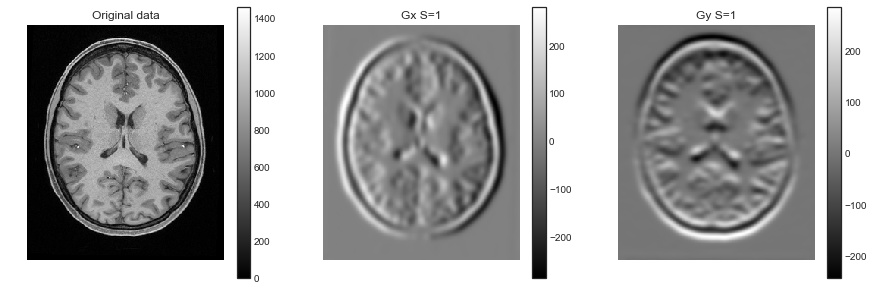

In [2]:
# Load some brain data
t1 = nibabel.load('data/HCP/100307/T1w_acpc_dc_restore.nii.gz').get_data()
# Select a single slice, convert to double and flip around so that it looks right side up
z = 120
data = t1.astype(np.double)[:,:,z]

# Apply a Gaussian filter at a scale of 1
gx, gy = gaussian_gradient_filter(data, scale=2)

plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(data[:,::-1].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Original data')

plt.subplot(1,3,2)
plt.imshow(gx[:,::-1].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Gx S=1')

plt.subplot(1,3,3)
plt.imshow(gy[:,::-1].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Gy S=1')



## Compute along any direction via rotation

Text(0.5,1,'-45 degree')

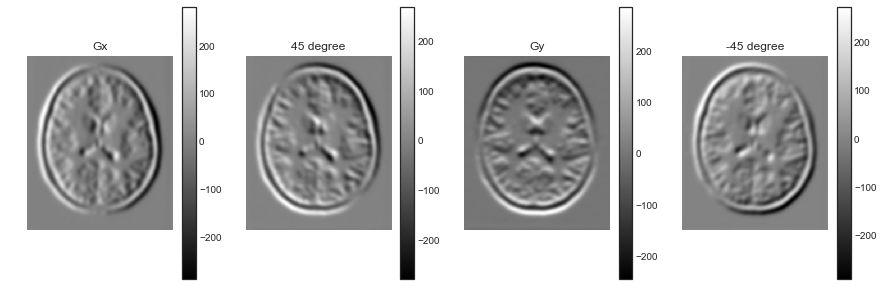

In [3]:
plt.figure(figsize=[15,5])
plt.subplot(1,4,1)
plt.imshow(gx[:,::-1].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Gx')

plt.subplot(1,4,2)
plt.imshow((1/math.sqrt(2)*gx + 1/math.sqrt(2)*gy)[:,::-1].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('45 degree')

plt.subplot(1,4,3)
plt.imshow(gy[:,::-1].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Gy')

plt.subplot(1,4,4)
plt.imshow((1/math.sqrt(2)*gx - 1/math.sqrt(2)*gy)[:,::-1].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('-45 degree')


## Also works in 3D

Text(0.5,1,'Gz S=1')

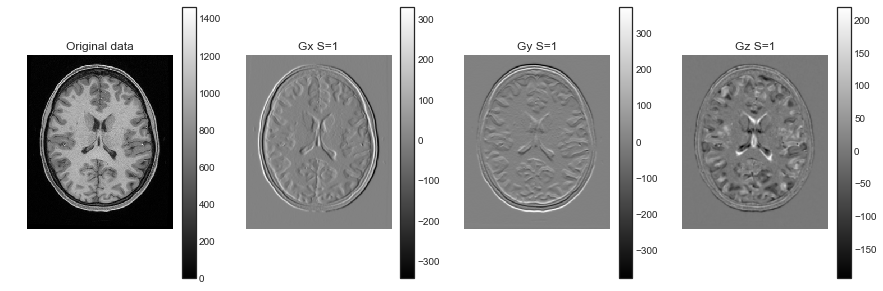

In [4]:
data = t1.astype(np.double)

# Apply a Gaussian filter at a scale of 1
gx, gy, gz = gaussian_gradient_filter(data, scale=0)

plt.figure(figsize=[15,5])
plt.subplot(1,4,1)
plt.imshow(data[:,::-1,z].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Original data')

plt.subplot(1,4,2)
plt.imshow(gx[:,::-1,z].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Gx S=1')

plt.subplot(1,4,3)
plt.imshow(gy[:,::-1,z].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Gy S=1')

plt.subplot(1,4,4)
plt.imshow(gz[:,::-1,z].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Gz S=1')